In [39]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import ttest_ind, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV, ElasticNetCV, LinearRegression
from sklearn.model_selection import KFold

In [30]:
# ------------------------
# 1. Load your data
# ------------------------
# Your protein data: rows = samples, columns = protein IDs, plus metadata columns
# Example: data.csv contains columns: ['SampleID', 'Age', 'Cohort', protein1, protein2, ...]
data = pd.read_csv("../data/processed/ProteinsForAgingPredictionModel.csv")
all_proteins = data.columns[3:]
data

,sample_id,Age,Cohort,IGKV3-7,IGLV4-69,IGLV8-61,IGLV4-60,IGLV7-46,IGLV2-18,IGLV3-10,...,NUMBL,MAP3K4,FCGBP,CAPN7,WASF2,ENPP4,IVNS1ABP,SEC23IP,LY96,COLEC10
0,1,39,Acute,-0.091532,-1.366104,-1.145562,-0.711261,-0.568527,-0.795973,-2.160702,...,-0.875210,0.299051,-0.438888,-1.245581,-0.213455,-0.257608,0.717860,-0.192076,0.109167,-0.053237
1,10,62,Acute,-0.084381,0.324336,-0.550176,0.262388,2.286182,-0.662100,0.215689,...,-0.718264,0.682764,0.947482,-1.765522,0.151322,0.129164,-0.005077,-0.369421,-0.211345,-1.100422
2,98,74,Acute,-1.235239,-0.463129,-0.731449,-0.730240,-0.915690,-1.042119,-1.043537,...,-1.545548,-0.116935,0.617791,0.283290,-1.983969,2.035058,0.968391,1.428078,-1.976120,-1.426767
3,101,39,PASC,-0.364035,0.626469,0.699974,0.596424,-0.356393,-0.190564,0.124930,...,-0.211603,-1.432963,1.133641,0.588104,0.723426,0.082765,-0.397765,0.222096,-0.336616,0.791749
4,102,20,PASC,0.541235,-0.129245,1.410942,1.242208,1.876388,1.023563,0.943350,...,-0.245993,-1.262268,-0.243519,-0.706828,-1.659900,0.296878,0.236090,0.000623,1.431196,0.862302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,385,83,Acute_NC,-1.029483,0.389658,-0.579216,2.597792,-0.317159,-0.187891,-0.555898,...,1.040956,-0.203914,-0.149142,2.357291,-0.724125,-1.863283,-0.700787,-3.579578,2.568199,1.307797
326,386,75,Acute_NC,0.641714,1.051544,1.104826,0.515698,-0.013729,1.442760,0.226253,...,2.041875,-1.440729,0.055593,1.845111,1.391338,-3.998078,-0.187420,-1.162157,1.427988,1.780027
327,387,50,Acute_NC,0.313381,1.531319,-0.637522,-1.305907,-1.232598,1.086869,-0.405992,...,0.580525,0.462291,-0.601346,0.696342,0.214694,-0.452863,-0.201301,0.009652,0.339686,0.961744
328,388,53,Acute_NC,-1.071941,-1.835122,0.873761,-0.532001,-0.918749,-1.907013,0.275707,...,2.912204,0.411881,-2.154021,2.608730,1.281812,-1.263369,0.716707,-0.542545,0.070238,-1.423136


In [31]:
all_proteins

Index(['IGKV3-7', 'IGLV4-69', 'IGLV8-61', 'IGLV4-60', 'IGLV7-46', 'IGLV2-18',
       'IGLV3-10', 'IGLV3-9', 'IGKV2-28;IGKV2D-28', 'IGHV3-64',
       ...
       'NUMBL', 'MAP3K4', 'FCGBP', 'CAPN7', 'WASF2', 'ENPP4', 'IVNS1ABP',
       'SEC23IP', 'LY96', 'COLEC10'],
      dtype='object', length=6972)

In [72]:
# Load model coefficients: two columns ['Protein', 'Coefficient']
coeffs = pd.read_csv("../data/processed/Lehallier2019_ModelCoefficients_fixed.csv")

# Ensure intercept is stored (if available)
intercept = coeffs.loc[coeffs['Variable'] == '(Intercept)', 'Coefficients'].values[0]
coeffs = coeffs[coeffs['Variable'] != '(Intercept)']

# Take the higher coefficient for the duplicates
coeffs = (
    coeffs
    .sort_values('Coefficients', ascending=False)
    .drop_duplicates(subset='Variable', keep='first')
    .reset_index(drop=True)
)

#coeffs['ScaledCoefficients'] = (coeffs['Coefficients'] * 5)

coeffs

,Variable,Coefficients
0,SCARF2,2.259681
1,ARFIP2,1.734075
2,SOST,1.685101
3,PTN,1.640670
4,WFDC2,1.354360
...,...,...
363,CHAD,-0.781697
364,MSMP,-0.902728
365,CD93,-0.908136
366,IGDCC4,-1.076530


In [73]:
# ------------------------
# 2. Match proteins between model and your dataset
# ------------------------
model_proteins = coeffs['Variable'].tolist()
available_proteins = [p for p in model_proteins if p in data.columns]

print(f"Model uses {len(model_proteins)} proteins, found {len(available_proteins)} in your data")

# Subset data and coefficients to matched proteins
coeffs = coeffs[coeffs['Variable'].isin(available_proteins)]
X = data[available_proteins]

Model uses 368 proteins, found 188 in your data


In [75]:
# ------------------------
# 3. Apply the model
# ------------------------
# Compute predicted age
beta = coeffs.set_index('Variable')['Coefficients']
pred_age = intercept + np.dot(X, beta)

data['Predicted_Age'] = pred_age

# ------------------------
# 4. Model performance
# ------------------------
true_age = data['Age']
mae = mean_absolute_error(true_age, pred_age)
r2 = r2_score(true_age, pred_age)
corr, p_corr = pearsonr(true_age, pred_age)

print(f"Model Performance:\n MAE: {mae:.2f}\n R²: {r2:.3f}\n Pearson r: {corr:.3f} (p={p_corr:.2e})")

Model Performance:
 MAE: 11.33
 R²: 0.155
 Pearson r: 0.529 (p=3.39e-25)


In [32]:
cv = KFold(n_splits=10)

fitt = LassoCV(alphas=[0.01, 0.1, 1], max_iter=10000, random_state=1234, cv=cv, n_jobs=12).fit(X=data[all_proteins], y=data['Age'])



In [70]:
fitt.alpha_

0.1

In [71]:
(fitt.coef_ != 0).sum()

281

In [38]:
fitt.score

<bound method RegressorMixin.score of LassoCV(alphas=[0.01, 0.1, 1],
        cv=KFold(n_splits=10, random_state=None, shuffle=False), max_iter=10000,
        n_jobs=12, random_state=1234)>

More than two cohorts detected; consider ANOVA or linear model.


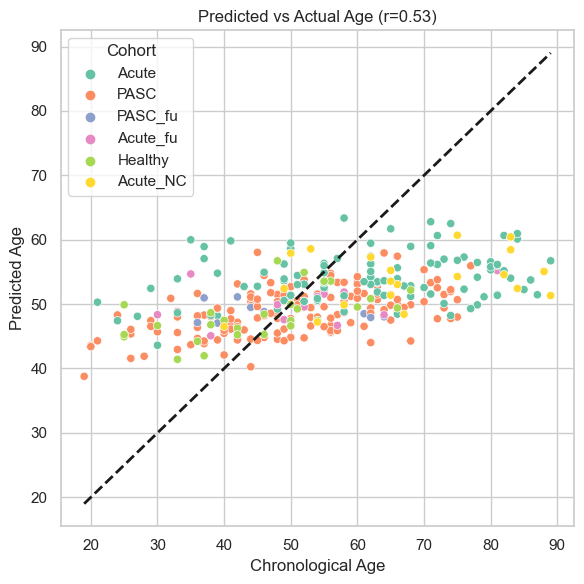

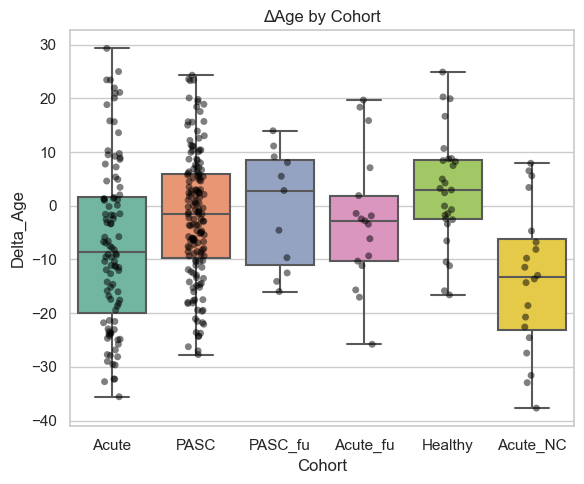

In [76]:
# ------------------------
# 5. Compute ΔAge
# ------------------------
data['Delta_Age'] = data['Predicted_Age'] - data['Age']

# ------------------------
# 6. Compare cohorts
# ------------------------
# Assuming Cohort column has two groups: 'Group1', 'Group2'
cohort_groups = data['Cohort'].unique()
if len(cohort_groups) == 2:
    group1 = data.loc[data['Cohort'] == cohort_groups[0], 'Delta_Age']
    group2 = data.loc[data['Cohort'] == cohort_groups[1], 'Delta_Age']
    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
    print(f"\nΔAge difference between cohorts:\n t={t_stat:.3f}, p={p_val:.3e}")
else:
    print("More than two cohorts detected; consider ANOVA or linear model.")

# ------------------------
# 7. Plots
# ------------------------
sns.set(style="whitegrid")

# Predicted vs Actual Age
plt.figure(figsize=(6,6))
sns.scatterplot(x=true_age, y=data['Predicted_Age'], hue=data['Cohort'], palette="Set2")
plt.plot([true_age.min(), true_age.max()], [true_age.min(), true_age.max()], 'k--', lw=2)
plt.xlabel("Chronological Age")
plt.ylabel("Predicted Age")
plt.title(f"Predicted vs Actual Age (r={corr:.2f})")
plt.tight_layout()
plt.show()

# ΔAge by Cohort
plt.figure(figsize=(6,5))
sns.boxplot(x='Cohort', y='Delta_Age', data=data, palette="Set2")
sns.stripplot(x='Cohort', y='Delta_Age', data=data, color='black', alpha=0.5)
plt.title("ΔAge by Cohort")
plt.tight_layout()
plt.show()

In [60]:
fit = LinearRegression().fit(X=X, y=data['Age'])

In [61]:
fit.coef_

array([ 8.3475736 ,  1.89599868,  2.18824489,  0.57894408,  2.52321348,
        1.07296429,  1.9254927 ,  3.15092072, -1.36289535,  1.50067876,
        2.2489589 ,  0.38413498,  0.09591995, -0.38661008,  1.50110517,
       -1.20565391,  1.69802538, -1.81063525,  1.51324824,  0.57600852,
       -0.38870568,  1.88730689,  0.36351852, -0.06602742, -0.41740542,
       -1.15019399,  2.08820436,  2.27632284,  1.1301834 , -3.55687922,
        1.11835835, -0.10129415,  0.97437226, -0.02453033, -1.41043901,
        0.15044057, -0.07739445, -1.62704764, -0.03642938,  0.27881303,
       -0.31877889, -2.26701487,  1.29565751,  0.08754037,  0.69869131,
       -1.32983991,  1.35254865, -0.68080956,  0.21333931, -0.69917557,
        1.19367635, -0.79838203,  1.29546923, -1.14546226, -2.71743698,
        1.26989545,  1.1571892 , -0.54305949,  1.72446047, -0.45790028,
        1.08880902, -0.3829438 , -0.15782601,  1.74728507, -0.30047079,
        0.5708749 , -0.64102751, -4.81496581,  0.01260748,  3.02

In [62]:
protein_to_coef_map = {x: y for x, y in zip(available_proteins, fit.coef_)}
protein_to_coef_map

{'SOST': 8.347573602538024,
 'PTN': 1.8959986824679618,
 'GDF15': 2.188244891562362,
 'ADAMTS5': 0.5789440750864492,
 'MLN': 2.523213481585298,
 'C1QTNF3': 1.072964288316809,
 'CTSF': 1.9254926950756506,
 'SVEP1': 3.150920722130622,
 'CCDC80': -1.3628953534033545,
 'PTGDS': 1.5006787592306485,
 'DPT': 2.248958898429571,
 'DCTPP1': 0.38413497912396943,
 'ASPN': 0.09591994927640446,
 'PLXNB2': -0.38661008145023035,
 'ITGAV': 1.5011051733168246,
 'CHRDL1': -1.2056539059087488,
 'TNFRSF11B': 1.698025379152485,
 'NCAM1': -1.8106352506862466,
 'LAG3': 1.5132482394291804,
 'NPW': 0.5760085233942748,
 'FAS': -0.38870568068861183,
 'DCBLD2': 1.8873068926166328,
 'F8': 0.3635185221735002,
 'MCFD2': -0.06602742223130709,
 'BGN': -0.41740541882595616,
 'APOB': -1.150193986138196,
 'GMFG': 2.088204363548852,
 'COCH': 2.2763228385339396,
 'GP5': 1.1301834049205053,
 'SELP': -3.5568792167398837,
 'TBCA': 1.1183583534979933,
 'SEC13': -0.10129414661376085,
 'LAMA1': 0.9743722627618254,
 'PLXNC1': -0.0

In [63]:
coeffs['my_coef'] = coeffs['Variable'].map(protein_to_coef_map)
coeffs

C:\Users\beimers\AppData\Local\Temp\ipykernel_39996\488602716.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coeffs['my_coef'] = coeffs['Variable'].map(protein_to_coef_map)


,Variable,Coefficients,my_coef
2,SOST,1.685101,8.347574
3,PTN,1.640670,1.895999
5,GDF15,1.275807,2.188245
9,ADAMTS5,0.742040,0.578944
10,MLN,0.667658,2.523213
...,...,...,...
360,SCG3,-0.648221,0.445666
361,CDON,-0.657692,-0.537978
362,COL15A1,-0.717762,2.558962
363,CHAD,-0.781697,0.778850


In [65]:
coeffs[['Coefficients', 'my_coef']].corr()

,Coefficients,my_coef
Coefficients,1.000000,0.292892
my_coef,0.292892,1.000000


<AxesSubplot:xlabel='Coefficients', ylabel='my_coef'>

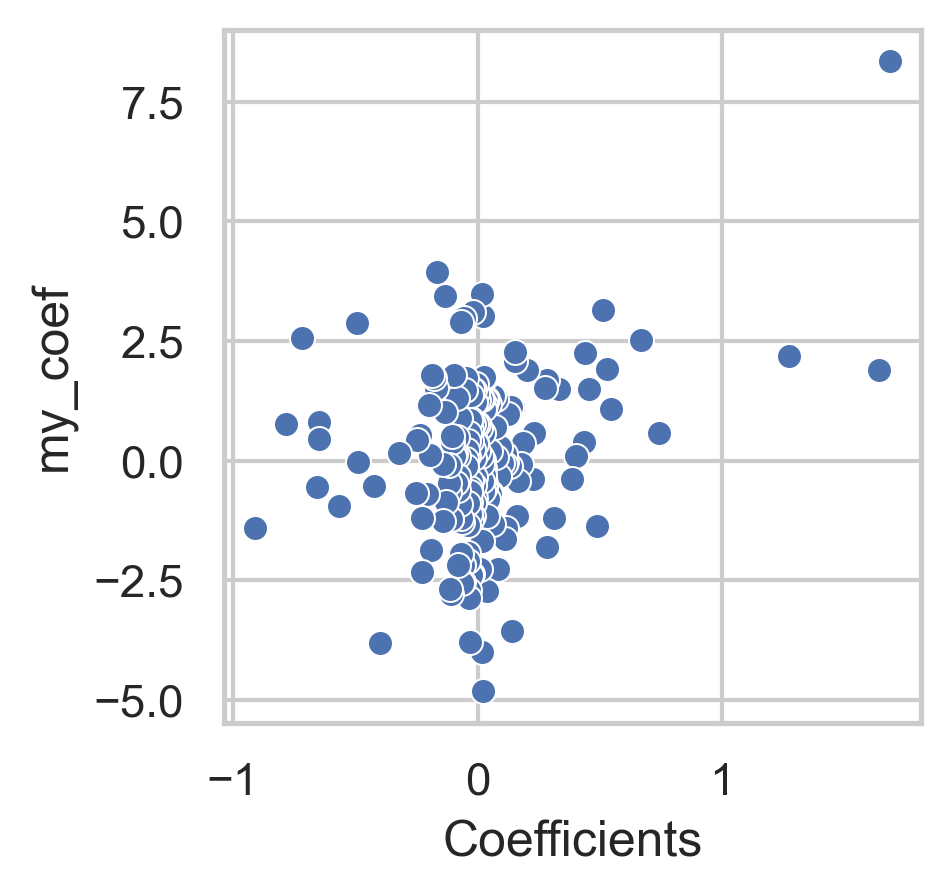

In [64]:
fig, ax = plt.subplots(dpi=300, figsize=(3, 3))

sns.scatterplot(data=coeffs, x='Coefficients', y='my_coef')

In [53]:
coeffs['Variable'].value_counts()

LEPR      2
SVEP1     2
SOST      1
APOE      1
PSMA1     1
         ..
PLXNC1    1
PRNP      1
SIT1      1
GOLM1     1
CXCL1     1
Name: Variable, Length: 188, dtype: int64